# Calculation of the Bayesian Evidence for a Gaussian Linear Model

The idea is to use a quadratic function to fit some data, calculate the Bayesian Evidence $\mathcal{P}\left(\mathcal{D}\right)$ analytically and see if we can recover the Bayesian Evidence from an MCMC chain. In particular, we will use Gibbs Sampling to sample for each parameter. 

## Generate the Data

In [1]:
# Import the relevant modules
'==========================================================================================='
import numpy as np 
import matplotlib.pylab as plt 
from numpy.linalg import inv
from numpy.linalg import det
from functools import reduce
import sklearn as skl
import statistics
from sklearn.neighbors import NearestNeighbors, DistanceMetric
import scipy.special as sp
import math
%matplotlib inline

In [5]:
# Matplotlib Settings
'==========================================================================================='
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['text.latex.preamble']=["\usepackage{amsmath}"]
fontSize = 15
figSize  = (10, 6)

Recall that, we are trying to fit a quadratic function $\left(\theta_{0}+\theta_{1}x+\theta_{2}x^{2}\right)$ to the data which is corrupted by Gaussian noise. The noise has a standard deviation $\sigma=0.2$. The true values of the parameters $\left(\theta_{0},\,\theta_{1},\,\theta_{2}\right)$ are 1.0, 4.0 and -1.0 respectively. 

In [17]:
# Generate Data for a Quadratic Function
'==========================================================================================='
xmin        = 0.0
xmax        = 4.0
nDataPoints = 200
x           = np.linspace(xmin, xmax, nDataPoints)

# True Parameters
'==========================================================================================='
theta0_true = 1.0
theta1_true = 4.0
theta2_true = -1.0

theta_true = np.array([theta0_true, theta1_true, theta2_true])

def quadratic(parameters):
	return parameters[0] + parameters[1]*x + parameters[2]*x**2

y          = quadratic(theta_true)
sigmaNoise = np.ones(len(x))*0.2
yNoisy     = y + np.random.normal(0.0, sigmaNoise)

## Plot the Data

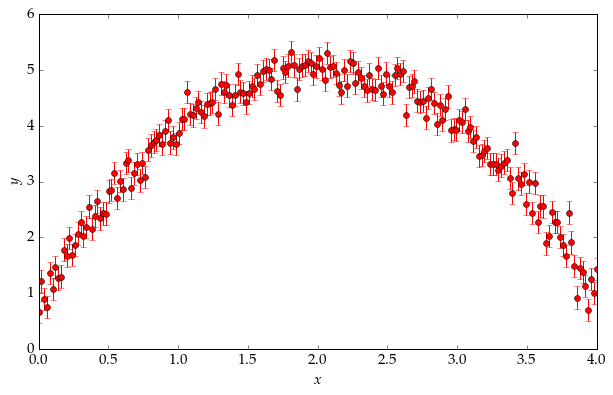

In [7]:
# Plot the data 
'==========================================================================================='
plt.figure(figsize = figSize)
plt.errorbar(x, yNoisy, yerr = sigmaNoise, fmt = 'ro')
plt.xlabel('$x$', fontsize = fontSize)
plt.ylabel('$y$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

## Analytical Calculation of the Bayesian Evidence

We first construct the following vectors/matrices:

$$
\mathbf{D}=\left(\begin{array}{ccc}
\frac{1}{\sigma_{0}} & \frac{x_{0}}{\sigma_{0}} & \frac{x_{0}^{2}}{\sigma_{0}}\\
\\
\vdots & \vdots & \vdots\\
\\
\frac{1}{\sigma_{N-1}} & \frac{x_{N-1}}{\sigma_{N-1}} & \frac{x_{N-1}^{2}}{\sigma_{N-1}}
\end{array}\right)\hspace{2cm}\mathbf{b}=\left(\begin{array}{c}
\frac{y_{0}}{\sigma_{0}}\\
\\
\vdots\\
\\
\frac{y_{N-1}}{\sigma_{N-1}}
\end{array}\right)
$$

where we have $N = 200$ data points. 

Therefore, we can write the likelihood as 

$$
\mathcal{P}\left(\mathcal{D}\left|\boldsymbol{\theta}\right.\right)=k\,\textrm{exp}\left[-\dfrac{1}{2}\left(\mathbf{b}-\mathbf{D}\boldsymbol{\theta}\right)^{\textrm{T}}\left(\mathbf{b}-\mathbf{D}\boldsymbol{\theta}\right)\right]
$$ 

where $\mathcal{D}$ is the observed data and $k=\dfrac{1}{\prod_{i}\sqrt{\left(2\pi\sigma_{i}^{2}\right)}}$. We assume uniform priors of width, $\Delta\theta_{j}\,\left(j=0,\,1,\,2\right)$ equal to 10 on each parameter, that is, $\mathcal{P}\left(\theta_{j}\right)=\dfrac{1}{\Delta\theta_{j}}$. Hence, the Bayesian Evidence:

$$
\mathcal{P}\left(\mathcal{D}\right)=\int\mathcal{P}\left(\mathcal{D}\left|\boldsymbol{\theta}\right.\right)\mathcal{P}\left(\boldsymbol{\theta}\right)\,d\boldsymbol{\theta}
$$ 

$$
\mathcal{P}\left(\mathcal{D}\right)=\dfrac{k}{\Delta\theta_{0}\Delta\theta_{1}\Delta\theta_{1}}\int\textrm{exp}\left[-\dfrac{1}{2}\left(\mathbf{b}-\mathbf{D}\boldsymbol{\theta}\right)^{\textrm{T}}\left(\mathbf{b}-\mathbf{D}\boldsymbol{\theta}\right)\right]\,d\boldsymbol{\theta}
$$

$$
\mathcal{P}\left(\mathcal{D}\right)=\dfrac{k\left|2\pi\left(\mathbf{D}^{\textrm{T}}\mathbf{D}\right)^{-1}\right|}{\Delta\theta_{0}\Delta\theta_{1}\Delta\theta_{1}}\,\textrm{exp}\left[-\dfrac{1}{2}\left(\mathbf{b}^{\textrm{T}}\mathbf{b}-\mathbf{b}^{\textrm{T}}\mathbf{D}\left(\mathbf{D}^{\textrm{T}}\mathbf{D}\right)^{-1}\mathbf{D}^{\textrm{T}}\mathbf{b}\right)\right]
$$

In [18]:
# Calculate the Bayesian Evidence 
'==========================================================================================='

w0 = 10.0
w1 = 10.0
w2 = 10.0

D      = np.zeros(shape = (len(x), 3))
D[:,0] = 1.0/sigmaNoise
D[:,1] = x/sigmaNoise
D[:,2] = x**2/sigmaNoise
b      = yNoisy/sigmaNoise

num1 = np.log(det(2.0 * np.pi * inv(np.dot(D.T, D))))
num2 = -0.5 * (np.dot(b.T, b) - reduce(np.dot, [b.T, D, inv(np.dot(D.T, D)), D.T, b]))
den1 = np.log(w0 * w1 * w2)

log_Evidence = num1 + num2 - den1 #(We have ignored k)

print '\nThe log-Bayesian Evidence is equal to: {}'.format(log_Evidence)


The log-Bayesian Evidence is equal to: -131.312412971


## Gibbs Sampling

We can also use Gibbs sampling to find the posterior distribution for each parameter. We need the conditional distribution for each parameter. As an example, 

$$
\mathcal{P}\left(\theta_{0}\left|\theta_{1},\,\theta_{2},\,\mathcal{D}\right.\right)\sim\mathcal{N}\left(\mu,\,\sigma^{2}\right)
$$

where $\mu=\dfrac{\mathbf{b}^{\textrm{T}}\mathbf{D}_{0}-\boldsymbol{\theta}_{r}^{\textrm{T}}\mathbf{D}_{r}^{\textrm{T}}\mathbf{D}_{0}}{\mathbf{D}_{0}^{\textrm{T}}\mathbf{D}_{0}}$
  and $\sigma^{2}=\dfrac{1}{\mathbf{D}_{0}^{\textrm{T}}\mathbf{D}_{0}}
 . \mathbf{D}_{0}
 , \mathbf{D}_{r}
 , \boldsymbol{\theta}_{r}$
  are the appropriate vectors/matrices. 
  
The other two conditional distributions, namely, $$\mathcal{P}\left(\theta_{1}\left|\theta_{0},\,\theta_{2},\,\mathcal{D}\right.\right)$$
and 

$$\mathcal{P}\left(\theta_{2}\left|\theta_{0},\,\theta_{1},\,\mathcal{D}\right.\right)$$

can be derived in a similar and are also Gaussian distributed. 

In [19]:
# Gibbs Sampling
'==========================================================================================='

D0 = np.zeros(shape = (len(x), 2)); D0[:,0] = x/sigmaNoise; D0[:,1] = x**2/sigmaNoise 
D1 = np.zeros(shape = (len(x), 2)); D1[:,0] = 1./sigmaNoise; D1[:,1] = x**2/sigmaNoise 
D2 = np.zeros(shape = (len(x), 2)); D2[:,0] = 1./sigmaNoise; D2[:,1] = x/sigmaNoise 


def sample(params, label):

	if label == 't0':
		theta_r = np.array([params[1], params[2]])
		v       = 1.0/sigmaNoise
		A       = np.dot(v.T, v)
		B       = -2.0 * (np.dot(b.T, v) - reduce(np.dot, [theta_r.T, D0.T, v]))
		mu      = -B/(2.0 * A)
		sig     = np.sqrt(1.0/A)

	if label == 't1':
		theta_r = np.array([params[0], params[2]])
		v       = x/sigmaNoise
		A       = np.dot(v.T, v)
		B       = -2.0 * (np.dot(b.T, v) - reduce(np.dot, [theta_r.T, D1.T, v]))
		mu      = -B/(2.0 * A)
		sig     = np.sqrt(1.0/A)

	if label == 't2':
		theta_r = np.array([params[0], params[1]])
		v       = x**2/sigmaNoise
		A       = np.dot(v.T, v)
		B       = -2.0 * (np.dot(b.T, v) - reduce(np.dot, [theta_r.T, D2.T, v]))
		mu      = -B/(2.0 * A)
		sig     = np.sqrt(1.0/A)

	return np.random.normal(mu, sig)

def gibbs(params, Niters):

	Niters        = int(Niters)
	trace         = np.zeros(shape = (Niters, 3))
	logLikelihood = np.zeros(Niters) 

	for i in range(Niters):
		params[0]  = sample(params, 't0')
		params[1]  = sample(params, 't1')
		params[2]  = sample(params, 't2')

		trace[i,:] = params

		logLikelihood[i] = -0.5 * np.dot((b - np.dot(D,trace[i,:])).T, (b - np.dot(D,trace[i,:]))) 

	return trace, logLikelihood 

# Example - Calculate the MLE (We can start sampling from this point)
MLE = reduce(np.dot, [inv(np.dot(D.T, D)), D.T, b])

# Print the true values of the parameters and the MLE
print("""\n The Maximum Likelihood Estimators are:\n
	theta_0 = {0[0]:.3f} (truth: {1})\n
	theta_1 = {0[1]:.3f} (truth: {2})\n 
	theta_2 = {0[2]:.3f} (truth: {3})\n""".format(MLE, theta0_true, theta1_true, theta2_true))


 The Maximum Likelihood Estimators are:

	theta_0 = 0.951 (truth: 1.0)

	theta_1 = 4.070 (truth: 4.0)
 
	theta_2 = -1.020 (truth: -1.0)



## Testing the Gibbs Sampler

We show that the Gibbs Sampler is working fine, that is, we should expect Gaussian distributions around the true parameter values and we can also have a triangle plot to show the correlation among the parameters.

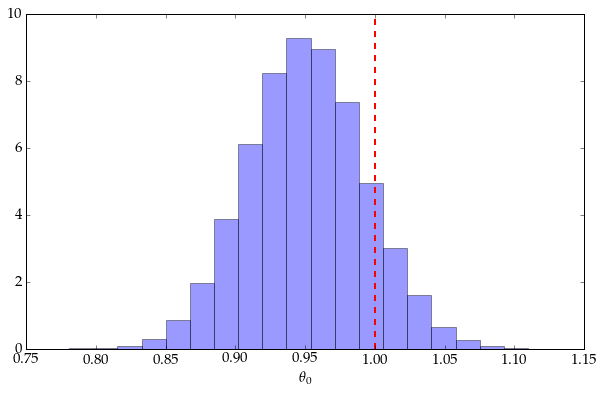

In [26]:
N_samples       = int(1E5)
samples, fs     = gibbs(MLE, N_samples)
samples_thinned = samples[int(0.2*N_samples):] # Neglect the first 10 % of the chain

# Histogram the first column (theta_0)

plt.figure(figsize = figSize)
plt.hist(samples_thinned[:,0], normed = True, bins = 20, alpha = 0.4)
plt.axvline(theta0_true, lw = 2, linestyle = '--', c = 'r')
plt.xlabel('$\\theta_{0}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

In [27]:
fs

array([-104.21673879, -104.8792818 , -105.36001298, ..., -105.04262262,
       -104.22152911, -104.52411703])

Here we show a triangle plot not only to illustrate the correlation among the parameters, but also to show that the Gibbs sampling is good. (This is not part of the code so that anyone else can run the notebook. I used the package chainconsumer to make the triangle plot.)

<img src="Triangle_plot.png" alt="Correlation" align="middle" width="50%" height="50%">

## Implementing our Method

Here, I simply copy and paste part of the code which Alan and Yabe have written. I assume the steps and procedures stay the same. We only need the samples to calculate the Bayesian Evidence.

In [32]:
# Implement our Method
'==========================================================================================='

Ntrials = 20
powmin  = 3
powmax  = 5
kmax    = 5

mle     = np.zeros((Ntrials,kmax+1))
powers  = np.zeros(Ntrials)
nchain  = np.zeros(Ntrials)
ndim    = 3.


for ipow in range (0,Ntrials):
    powers[ipow] = powmin+float(ipow)*(powmax-powmin)/float(Ntrials-1)
    nchain[ipow] = int(pow(10.,powers[ipow]))
    S            = int(nchain[ipow])
    
    DkNN    = np.zeros((S,kmax+1))
    indices = np.zeros((S,kmax+1))
    volume  = np.zeros((S,kmax+1))
    
# Generate samples in parameter space by Gibbs sampling (trivial since everything is separable):

    samples, fs = gibbs(MLE, S)

# Use sklearn nearest neightbour routine, which chooses the 'best' algorithm.
# This is where the hard work is done:

    nbrs          = NearestNeighbors(n_neighbors=kmax+1, algorithm='auto').fit(samples)
    DkNN, indices = nbrs.kneighbors(samples)
    
# Create the posterior for 'a' from the distances (volumes) to nearest neighbour:

    for k in range(1,kmax):
        for j in range(0,S):
        
# Use analytic formula for the volume of ndim-sphere:
            volume[j,k] = math.pow(math.pi,ndim/2.)*math.pow(DkNN[j,k],ndim)/sp.gamma(1.+ndim/2.)

# dotp is the summation term in the notes:
        dotp = np.dot(volume[:,k],np.exp(fs))
        
# The MAP value of 'a' is obtained analytically from the expression for the posterior:
        amax = dotp/(S*k+1.0)
    
# Maximum likelihood estimator for the evidence (this is normalised to the analytic value):
        mle[ipow,k] = S*amax
    
    if ipow==0: 
        print('ipow','S','k','fs','dotp','statistics.median(volume[:,k])','amax','MLE[ipow,k]')
    print(ipow,S,k,np.max(fs),dotp,statistics.median(volume[:,k]),amax,mle[ipow,k])

('ipow', 'S', 'k', 'fs', 'dotp', 'statistics.median(volume[:,k])', 'amax', 'MLE[ipow,k]')
(0, 1000, 4, -103.70442873008631, 1.8099581232711867e-49, 3.8479535427046174e-07, 4.5237643670861955e-53, 4.5237643670861953e-50)
(1, 1274, 4, -103.6991445927182, 1.6156111066875516e-49, 3.5727055968041478e-07, 3.1697294618158754e-53, 4.038235334353425e-50)
(2, 1623, 4, -103.70392603644638, 1.503437421603599e-49, 2.4225307024494981e-07, 2.3154742362599709e-53, 3.7580146854499327e-50)
(3, 2069, 4, -103.70206916844307, 1.4566728076629183e-49, 1.9597160547143297e-07, 1.7599043224150275e-53, 3.6412420430766919e-50)
(4, 2636, 4, -103.69745725034163, 1.3622096303280782e-49, 1.4303865049992079e-07, 1.2918061928194199e-53, 3.4052011242719909e-50)
(5, 3359, 4, -103.70180642340404, 1.3515181631650222e-49, 1.0982900286434038e-07, 1.0058183844347862e-53, 3.3785439533164468e-50)
(6, 4281, 4, -103.70104781022269, 1.3160408771348423e-49, 9.5985641448535066e-08, 7.6849102314443343e-54, 3.2899100700813197e-50)
(7,

## Plotting the Results Obtained

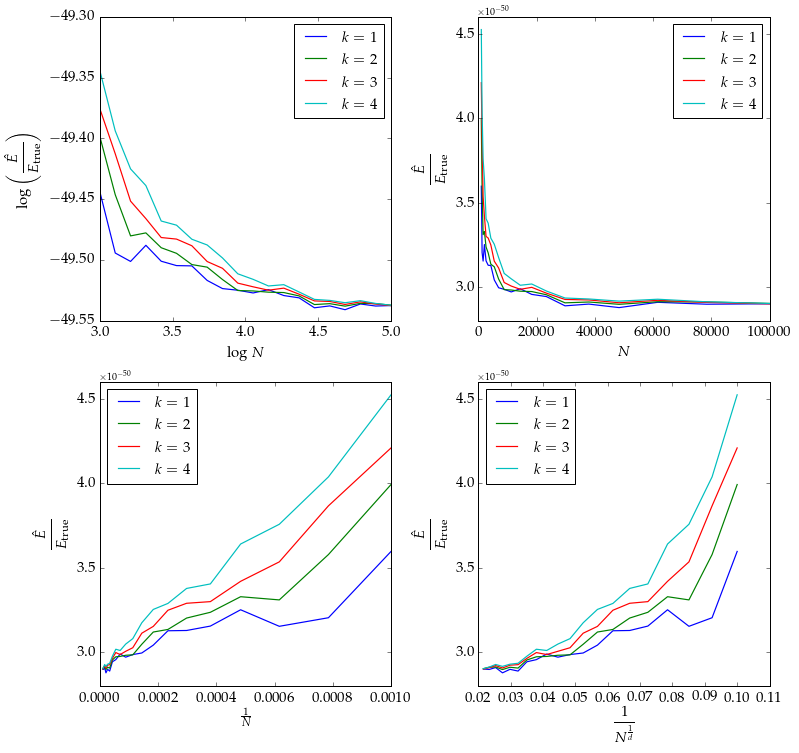

In [33]:
left    = None  # the left side of the subplots of the figure
right   = None  # the right side of the subplots of the figure
bottom  = None  # the bottom of the subplots of the figure
top     = None  # the top of the subplots of the figure
wspace  = 0.3   # the amount of width reserved for blank space between subplots
hspace  = 0.2   # the amount of height reserved for white space between subplots


fig,ax=plt.subplots(figsize=(12,12))

plt.subplot(2,2,1)

plt.plot(powers,np.log10(mle[:,1]), lw = 1.2, label = '$k=1$')
plt.plot(powers,np.log10(mle[:,2]), lw = 1.2, label = '$k=2$')
plt.plot(powers,np.log10(mle[:,3]), lw = 1.2, label = '$k=3$')
plt.plot(powers,np.log10(mle[:,4]), lw = 1.2, label = '$k=4$')
plt.xlabel('$\\textrm{log }N$', fontsize = fontSize)
plt.ylabel('$\\textrm{log}\left(\dfrac{\hat{E}}{E_{\\textrm{true}}}\\right)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc=1,prop={'size':15})

plt.subplot(2,2,2)
plt.plot(nchain,mle[:,1], lw = 1.2, label = '$k=1$')
plt.plot(nchain,mle[:,2], lw = 1.2, label = '$k=2$')
plt.plot(nchain,mle[:,3], lw = 1.2, label = '$k=3$')
plt.plot(nchain,mle[:,4], lw = 1.2, label = '$k=4$')
plt.xlabel('$N$', fontsize = fontSize)
plt.ylabel('$\dfrac{\hat{E}}{E_{\\textrm{true}}}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc=1,prop={'size':15})

plt.subplot(2,2,3)
plt.plot(1/nchain,mle[:,1], lw = 1.2, label = '$k=1$')
plt.plot(1/nchain,mle[:,2], lw = 1.2, label = '$k=2$')
plt.plot(1/nchain,mle[:,3], lw = 1.2, label = '$k=3$')
plt.plot(1/nchain,mle[:,4], lw = 1.2, label = '$k=4$')
plt.xlabel('$\\frac{1}{N}$', fontsize = fontSize)
plt.ylabel('$\dfrac{\hat{E}}{E_{\\textrm{true}}}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc=2,prop={'size':15})

plt.subplot(2,2,4)
plt.plot(pow(nchain,-1.0/ndim),mle[:,1], lw = 1.2, label = '$k=1$')
plt.plot(pow(nchain,-1.0/ndim),mle[:,2], lw = 1.2, label = '$k=2$')
plt.plot(pow(nchain,-1.0/ndim),mle[:,3], lw = 1.2, label = '$k=3$')
plt.plot(pow(nchain,-1.0/ndim),mle[:,4], lw = 1.2, label = '$k=4$')
plt.xlabel('$\dfrac{1}{N^{\\frac{1}{d}}}$', fontsize = fontSize)
plt.ylabel('$\dfrac{\hat{E}}{E_{\\textrm{true}}}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc=2,prop={'size':15})

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

plt.show()

In [39]:
#help(NearestNeighbors)
a=np.repeat(10.0,3)

In [40]:
a.prod()

1000.0